In [13]:
# import torchvision.datasets as datasets
# from torch.utils.data import DataLoader

# trainset = datasets.MNIST(root='./data', train=True, download=True)
# train_loader = DataLoader(trainset, batch_size=100, shuffle=True)

# plt.imshow(train_loader[0])

import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

# image = np.random.rand(32, 32)
# plt.imshow(image)
image = cv2.imread("./local_var.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = torch.from_numpy(image)

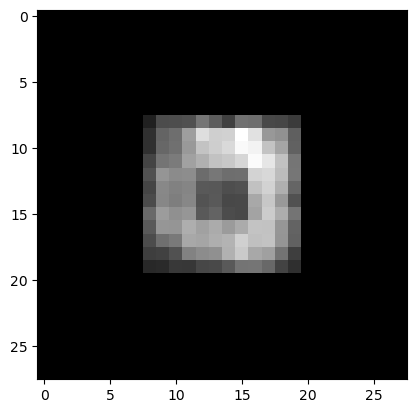

In [19]:
import cv2
import numpy as np

def variance_map(image: np.ndarray, kernel_size: int) -> np.ndarray:
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be odd.")
    
    pad_size = kernel_size // 2
    
    padded_image = cv2.copyMakeBorder(image, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_REFLECT)
    
    variance_map = np.zeros_like(image, dtype=np.float32)

    for i in range(pad_size, padded_image.shape[0] - pad_size):
        for j in range(pad_size, padded_image.shape[1] - pad_size):
            local_region = padded_image[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1]
            local_variance = np.var(local_region)
            variance_map[i-pad_size, j-pad_size] = local_variance
    
    return variance_map

image = cv2.imread('./local_var.png', cv2.IMREAD_GRAYSCALE)
kernel_size = 5
var_map = variance_map(image, kernel_size)

plt.imshow(var_map, cmap='gray')

In [16]:
image.shape

torch.Size([28, 28])

(28, 28, 3)


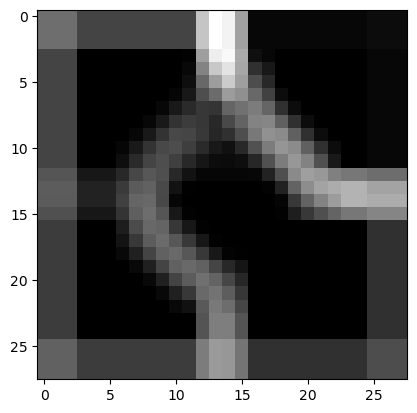

In [38]:
import torch
import torch.nn.functional as F

def variance_map(image: torch.Tensor, kernel_size: int) -> torch.Tensor:
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be odd.")
    
    pad_size = kernel_size // 2
    padded_image = F.pad(image, pad=(pad_size, pad_size, pad_size, pad_size), mode='reflect')
    
    local_mean = F.avg_pool2d(padded_image, kernel_size, stride=1, padding=0)
    
    squared_image = padded_image ** 2
    local_mean_squared = F.avg_pool2d(squared_image, kernel_size, stride=1, padding=0)
    
    variance = local_mean_squared - local_mean ** 2
    # variance = torch.mean(variance, dim=1, keepdim=True)
    
    return variance

image = cv2.imread('./apple_color.png')
image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Convert to [1, 3, H, W] format
var_map = variance_map(image_tensor, kernel_size=5)
var_map_image = var_map.squeeze(0).permute(1, 2, 0).numpy()
print(var_map_image.shape)
var_map_image = cv2.cvtColor(var_map_image, cv2.COLOR_BGR2GRAY)

plt.imshow(var_map_image, cmap='gray')

In [18]:
import torch
import torch.nn.functional as F

def calculate_divergence(image, kernels=[5, 11, 15]):
    # kernels = [5, 11, 15]
    div_images = []

    for kernel_size in kernels:
        # div = F.avg_pool2d(image.float(), kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        print(image.shape)
        # div = F.pad(image.float(), (kernel_size//2, kernel_size//2, kernel_size//2, kernel_size//2), mode='reflect')/255
        # div = F.avg_pool2d(div, kernel_size=kernel_size, stride=1, padding=0)
        div = F.avg_pool2d(image.float(), kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        print(div.shape)
        div_images.append(div)

    div_avg = sum(div_images) / len(kernels)
    
    return div_avg

div_image = calculate_divergence(image)
div_image = div_image.mean(dim=2)

print(div_image.size())

plt.imshow(div_image.reshape(28, 28))

torch.Size([28, 28])


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got -3)

In [10]:
def to_grayscale(image):
    return torch.mean(image, dim=1, keepdim=True)  # Averaging the RGB channels

gray_image = to_grayscale(image)

In [21]:
image.shape

torch.Size([1, 3, 32, 32])

In [ ]:
def calculate_latency(div_image, max_latency):
    min_div, max_div = div_image.min(), div_image.max()
    normalized_div = (div_image - min_div) / (max_div - min_div)  # Normalize divergence between 0 and 1
    latency = max_latency * (1 - normalized_div)  # Higher divergence -> lower latency, and vice versa
    return latency

max_latency = 100  # Maximum possible latency time
latency_image = calculate_latency(div_image, max_latency)

plt.imshow(latency_image.reshape(32, 32))


In [12]:
class RestrictedRateEncoder(torch.nn.Module):
    def __init__(self, time_window, fire_window_ratio):
        super(RestrictedRateEncoder, self).__init__()
        self.time_window = time_window
        self.fire_window_size = int(time_window * fire_window_ratio)

    def forward(self, gray_image, latency_image):
        batch_size, _, height, width = gray_image.shape
        spikes = torch.zeros(batch_size, height, width, self.time_window).to(gray_image.device)

        # Create spike trains based on latency and gray_image
        for t in range(self.time_window):
            firing_mask = ((t >= latency_image) & (t < latency_image + self.fire_window_size)).float()
            spike_prob = torch.rand(batch_size, height, width).to(gray_image.device)
            spikes[:, :, :, t] = (spike_prob < gray_image.squeeze(1)) * firing_mask

        return spikes

# Example parameters
time_window = 100
fire_window_ratio = 0.2  # Fire window is 1/5 of the total time window

# Initialize the encoder and generate spike trains
encoder = RestrictedRateEncoder(time_window, fire_window_ratio)
spike_trains = encoder(gray_image, latency_image)


In [20]:
gray_image.shape

torch.Size([1, 1, 32, 32])

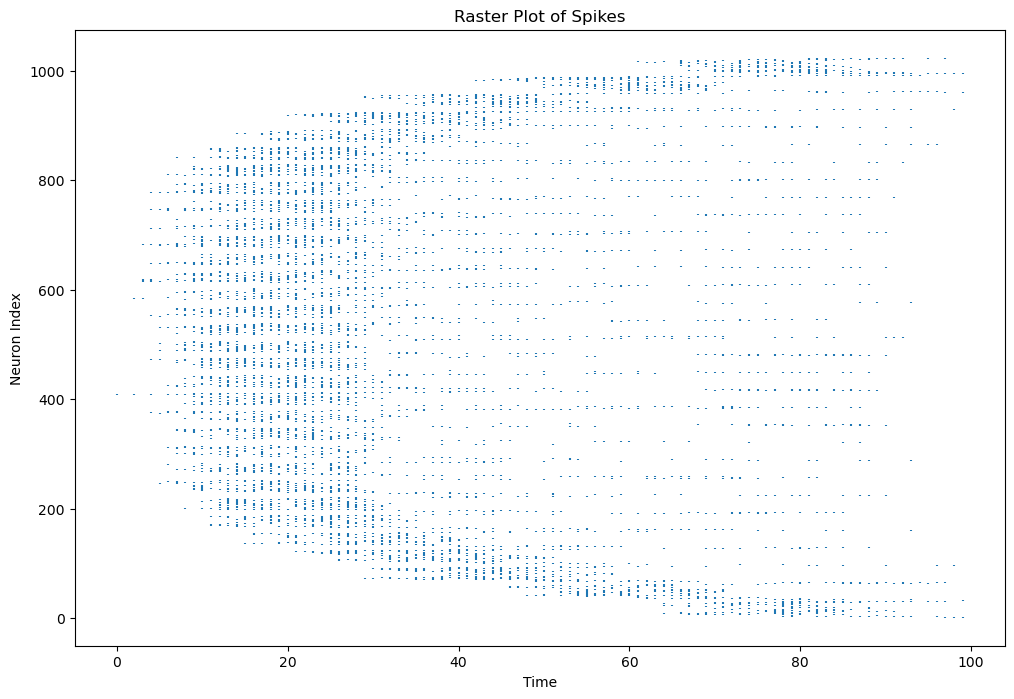

In [14]:
import matplotlib.pyplot as plt

def plot_raster(spike_trains, num_neurons=10):
    spike_trains = spike_trains.cpu().numpy()
    plt.figure(figsize=(12, 8))
    
    for neuron_idx in range(num_neurons):
        neuron_spikes = spike_trains[0, neuron_idx // 32, neuron_idx % 32]
        spike_times = neuron_spikes.nonzero()[0]
        plt.vlines(spike_times, neuron_idx + 0.5, neuron_idx + 1.5)
    
    plt.xlabel('Time')
    plt.ylabel('Neuron Index')
    plt.title('Raster Plot of Spikes')
    plt.show()

# Plot the raster plot for the first 10 neurons
plot_raster(spike_trains, num_neurons=32*32)


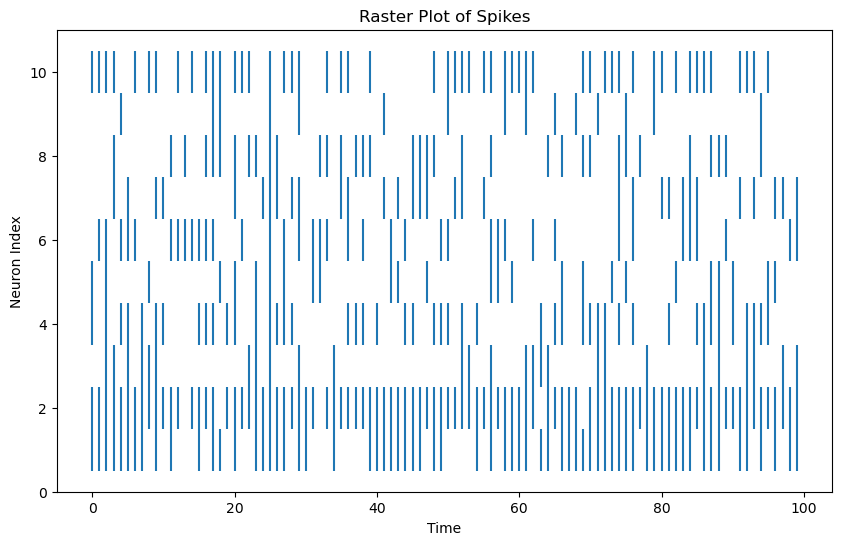

In [1]:
import torch
import matplotlib.pyplot as plt

# Assume the same encoder class and example input
class RateEncoder(torch.nn.Module):
    def __init__(self, num_neurons, time_window):
        super(RateEncoder, self).__init__()
        self.num_neurons = num_neurons
        self.time_window = time_window

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.unsqueeze(-1).repeat(1, 1, self.time_window)
        spikes = torch.rand(batch_size, self.num_neurons, self.time_window).to(x.device)
        return (spikes < x).float()

# Example usage
time_window = 100
num_neurons = 10  # smaller for visualization
batch_size = 1  # single input
input_data = torch.rand((batch_size, num_neurons))

encoder = RateEncoder(num_neurons, time_window)
spike_train = encoder(input_data)

# Visualization
plt.figure(figsize=(10, 6))
for neuron_idx in range(num_neurons):
    spike_times = torch.nonzero(spike_train[0, neuron_idx]).squeeze()
    plt.vlines(spike_times, neuron_idx + 0.5, neuron_idx + 1.5)

plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.title('Raster Plot of Spikes')
plt.show()
